# **--- `WfMi` : Measuring information ---**
---

In this tutorial, we're going to go through the following points :
1. **[$I(continuous, discret)$]** = Measure the quantity of information shared between brain data and stimulus (or outcome) types (\~decoding)
2. **[$I(continuous, continuous)$]** = Measure the quantity of information shared between brain data and a continuous variable (e.g. behavioral model like PE, the reaction time etc.) (\~regression)
4. How to handle the spatial dimension
    * Results at the single contact / channel level?
    * Results inside a brain region by grouping the data coming from multiple channels?
5. How to define a custom estimator of information

In [1]:
import os

import numpy as np
import xarray as xr
import pandas as pd

from mne.utils import ProgressBar

from frites.dataset import DatasetEphy
from frites.workflow import WfMi

import matplotlib.pyplot as plt

---
# **--- ROOT PATH ---**

<div class="alert alert-info"><p>

Define the path to where the data are located !
</p></div>

In [2]:
ROOT = '/run/media/etienne/DATA/Toolbox/BraiNets/CookingFrites/dataset/'

---
# **0 - Functions**

In [3]:
###############################################################################
###############################################################################
#                 Load the data of a single subject
###############################################################################
###############################################################################

def load_ss(subject_nb):
    """Load the data of a single subject.
    
    Parameters
    ----------
    subject_nb : int
        Subject number [0, 12]
    
    Returns
    -------
    hga : xarray.DataArray
        Xarray containing the high-gamma activity
    anat : pandas.DataFrame
        Table containing the anatomical informations
    beh : pandas.DataFrame
        Table containing the behavioral informations
    """
    # load the high-gamma activity
    file_hga = os.path.join(ROOT, 'hga', f'hga_s-{subject_nb}.nc')
    hga = xr.load_dataarray(file_hga)

    # load the name of the brain regions
    file_anat = os.path.join(ROOT, 'anat', f'anat_s-{subject_nb}.xlsx')
    anat = pd.read_excel(file_anat)

    # load the behavior
    file_beh = os.path.join(ROOT, 'beh', f'beh_s-{subject_nb}.xlsx')
    beh = pd.read_excel(file_beh)
    
    return hga, anat, beh


###############################################################################
###############################################################################
#                 Load the data of multiple subjects
###############################################################################
###############################################################################

def load_ms(s_range=[0, 11], model='outcome', condition='rew',
            space='channels', mean_roi=True, prepend_suj_to_ch=True):
    """Load multiple subjects.
    
    Parameters
    ----------
    s_range : int or list
        Subjects to load. Use either an integer (e.g. 7) to load a single
        subject or a range of subjects (e.g. [5, 10])
    model : {'outcome', 'pe', 'rt'}
        Model to use. Use either :
        
            * 'outcome' : find differences in the neural activity between the
              outcomes
            * 'pe' : find regions with an activity correlating with the
              prediction error
            * 'rt' : find regions with an activity correlating with the
              reaction time
    condition : {'rew', 'pun', 'context', 'null'}
        Condition to load. Use either :
        
            * 'rew' : for outcomes {+0€; +1€}
            * 'pun' : for outcomes {-1€; -0€}
            * 'context' : for outcomes {-1€; +1€}
            * 'null' : for outcomes {-0€; +0€}
    space : {'channels', 'roi'}
        Specify if the spatial dimension should be described with channel names
        or with brain region names
    mean_roi : bool
        Specify if you want to take the mean high-gamma activity inside a brain
        region
    prepend_suj_to_ch : bool
        Add subject name to each channel name
    
    Returns
    -------
    hga : list
        List of high-gamma activity across subjects
    """
    # inputs checking
    if isinstance(s_range, int):
        s_range = [s_range, s_range]
    s_range[1] += 1
    s_range[0], s_range[1] = max(s_range[0], 0), min(s_range[1], 12)
    mesg = f"Subject %i | model={model} | condition={condition} | space={space}"
    pbar = ProgressBar(range(s_range[0], s_range[1]), mesg=mesg % 0)
    model = model.lower()
    assert space in ['channels', 'parcels', 'roi']
    
    # get the code of the condition
    outc = {
        'rew': (+1, +2),
        'pun': (-2, -1),
        'context': (-2, +2),
        'null': (-1, +1)
    }[condition]
    
    # get the behavioral column to use
    col = {
        'outcome': 'code',
        'pe': 'PE',
        'rt': 'RT'
    }[model]
    
    # load the data
    hga = []
    for n_s in range(s_range[0], s_range[1]):
        pbar._tqdm.desc = mesg % n_s
        # load the data of a single subject
        _hga, _anat, _beh = load_ss(n_s)
        _outc = _hga['trials'].data
        _ch = _hga['channels'].data
        
        # replace trial dimension with the model
        _hga = _hga.rename(trials=model)
        _hga[model] = list(_beh[col])
        
        # get which outcome to keep
        keep_outc = np.logical_or(_outc == outc[0], _outc == outc[1])
        _hga = _hga[keep_outc, ...]
        
        # replace with brain regions
        if space in ['parcels', 'roi']:
            _hga = _hga.rename(channels=space)
            _hga[space] = list(_anat['roi'])
            
            # take the mean of the hga per parcel
            if mean_roi:
                _hga = _hga.groupby(space).mean(space)
        elif prepend_suj_to_ch and (space == 'channels'):
            # prepend subject number to channel name
            _hga['channels'] = [f"suj{n_s}/{c}" for c in _ch]
        
        # ascontinuous array
        _hga.data = np.ascontiguousarray(_hga.data)
        
        hga.append(_hga)
        pbar.update_with_increment_value(1)

    return hga

# **1. Loading multi-subjects**
## 1.1 Loading one or multiple subjects

In [7]:
# loading a single subject
# load_ms(s_range=0)
# load_ms(s_range=7)

# loading multiple subjects
# load_ms(s_range=[0, 1])
load_ms(s_range=[3, 6])

  0%|          | Subject 0 | model=outcome | condition=rew | space=channels : 0/4 [00:00<?,       ?it/s]

[<xarray.DataArray 'subject_3' (outcome: 240, channels: 2, times: 129)>
 array([[[ 0.21192235,  0.72830284,  0.69165826, ...,  1.9421154 ,
           0.29742542,  1.241406  ],
         [ 0.61670655,  0.817722  ,  0.5559789 , ...,  0.8252373 ,
           0.7121286 ,  0.7832431 ]],
 
        [[-0.3887279 , -0.31693307, -0.5888269 , ..., 14.374976  ,
          13.8677225 , 15.46017   ],
         [ 0.08245645,  0.59788746,  0.8184316 , ...,  2.393147  ,
           1.4652439 ,  1.7987863 ]],
 
        [[ 1.4517978 ,  1.21155   ,  0.9501936 , ...,  3.9626527 ,
           4.6416564 ,  7.244572  ],
         [-1.344311  , -0.82075816,  0.9004476 , ..., -0.33741713,
           0.4224237 ,  0.3551426 ]],
 
        ...,
 
        [[ 0.36031348, -0.35361817, -0.61010873, ...,  0.9266341 ,
          -0.6500678 ,  0.21796864],
         [ 0.62678695,  1.1928178 ,  1.7077204 , ..., -0.9893347 ,
          -0.30701286, -0.25862134]],
 
        [[-0.32315582, -0.51267356, -0.2578579 , ...,  1.4966538 ,
  

## 1.2 Choosing the model

- $I(continuous, discret)$
    * `'outcomes'` = **what are the contacts / brain regions for which the brain activity is different according to the outcome?**
- $I(continuous, continuous)$
    * `'pe'` (_prediction error_) = **what are the contacts / brain regions that correlates with the prediction error?**
    * `'rt'` (_reaction time_) = **what are the contacts / brain regions that correlates with the reaction time?**

In [ ]:
# seek for differences of activity between outcomes
# hga = load_ms(s_range=[0, 3], model='outcome')

# seek for correlation with the reaction time
hga = load_ms(s_range=[0, 3], model='rt')

# seek for correlation with the prediction error
hga = load_ms(s_range=[0, 3], model='pe')

## 1.3 Choosing the condition

Here, we only select the data for a subset of possible conditions, namely :
- **Reward condition     =** $outcomes \in \{"+0€", "+1€"\}$
- **Punishment condition =** $outcomes \in \{"-1€", "-0€"\}$
- **Context detection    =** $outcomes \in \{"-1€", "+1€"\}$
- **Null comparison      =** $outcomes \in \{"-0€", "+0€"\}$

Therefore, you can ask questions like :
- **Model-free analysis** (contrasting conditions, \~decoding)
    - Are there differences of HGA according to the outcome during the reward of punishment conditions?
    - What are the brain regions that can differentiate the context?
    - Are there regions capable of finding differences between the 0€ of both conditions?
- **Model-based analysis** (correlation with a model, \~regression)
- What are the brain regions correlating with the reward or punishment prediction error?
- Are there brain regions for which the brain activity correlates with the reaction time during the reward or punishment conditions?

### 1.3.1 Model-free analysis

In [ ]:
# Reward = differences of hga between outcomes (+0€; +1€)
hga = load_ms(s_range=[0, 3], model='outcome', condition='rew')

# Punishment = differences of hga between outcomes (-1€; -0€)
hga = load_ms(s_range=[0, 3], model='outcome', condition='pun')

# Context = differences of hga between outcomes (-1€; +1€)
hga = load_ms(s_range=[0, 3], model='outcome', condition='context')

# Null = differences of hga between outcomes (-0€; +0€)
hga = load_ms(s_range=[0, 3], model='outcome', condition='null')

### 1.3.2 Model-based analysis

In [ ]:
# brain regions correlating with the reward prediction error
hga = load_ms(s_range=[0, 3], model='pe', condition='rew')

# brain regions correlating with the punishment prediction error
hga = load_ms(s_range=[0, 3], model='pe', condition='pun')

# brain regions correlating with the reaction time during the reward condition
# hga = load_ms(s_range=[0, 3], model='rt', condition='rew')

# brain regions correlating with the reaction time during the punishment condition
# hga = load_ms(s_range=[0, 3], model='rt', condition='pun')

## 1.4 Choosing the spatial scale : channels or brain regions?
### 1.4.1 Computations at the scale of the channel / contact

In [ ]:
hga = load_ms(s_range=0, space='channels')

### 1.4.1 Computations at the scale of the brain region

In [ ]:
# use the brain region names to caracterize the space
hga = load_ms(s_range=7, space='roi', mean_roi=False)

# same, but this time we also take the mean of the hga inside each brain region
hga = load_ms(s_range=7, space='roi', mean_roi=True)

# **2. Measure information**
## 2.1 $I(continuous; discret)$ = Model-free analysis

  0%|          | Subject 0 | model=outcome | condition=rew | space=roi : 0/12 [00:00<?,       ?it/s]

Definition of an electrophysiological dataset
    Dataset composed of 12 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
Gaussian Copula Mutual Information Estimator (mi_type=cd, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (ffx - cd)
    Evaluate true and permuted mi (n_perm=0, n_jobs=-1)


  0%|          | Estimating MI : 0/4 [00:00<?,       ?it/s]

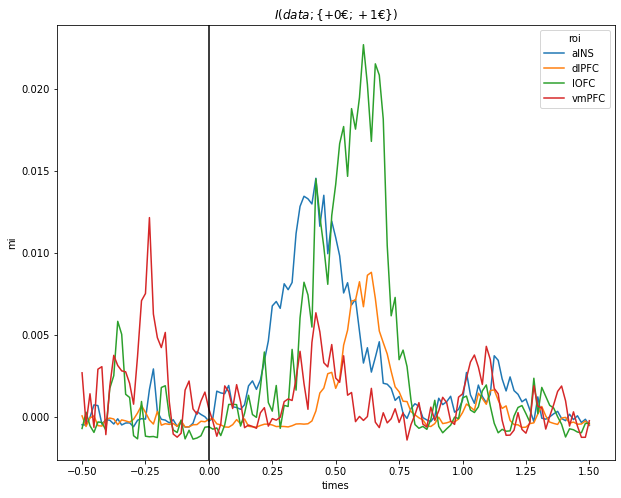

In [10]:
# load the hga, with the outcomes during the reward condition
hga = load_ms(model='outcome', condition='rew', space='roi')
# hga
# define the DatasetEphy
ds = DatasetEphy(hga, y='outcome', roi='roi', times='times')

# """
# define the type of mutual information to compute
# 'cd' = I(continuous; discret)
#      = I(brain data; stimulus)
# """
mi_type = 'cd'

# define a workflow of mutual-information
wf = WfMi(mi_type=mi_type, inference='ffx')

# run the workflow (without stat for the moment)
mi, pv = wf.fit(ds, mcp=None)

# plot the result
plt.figure(figsize=(10, 8))
mi.plot(x='times', hue='roi')
plt.axvline(0., color='k')
plt.title(r"$I(data; \{+0€; +1€\})$");

## 2.2 $I(continuous; continuous)$ = Model-based analysis

  0%|          | Subject 0 | model=pe | condition=pun | space=roi : 0/12 [00:00<?,       ?it/s]

Definition of an electrophysiological dataset
    Dataset composed of 12 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (ffx - cc)
    Evaluate true and permuted mi (n_perm=0, n_jobs=-1)


  0%|          | Estimating MI : 0/4 [00:00<?,       ?it/s]

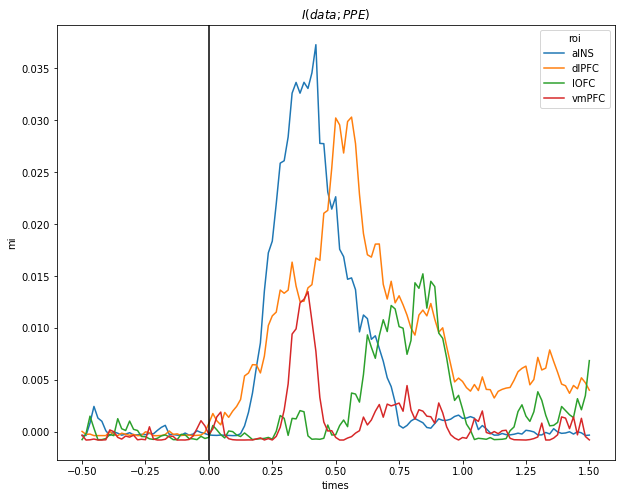

In [16]:
# load the hga, with the outcomes during the reward condition
hga = load_ms(model='pe', condition='pun', space='roi')

# define the DatasetEphy
ds = DatasetEphy(hga, y='pe', roi='roi', times='times')

"""
define the type of mutual information to compute
'cc' = I(continuous; continuous)
     = I(brain data; PE)
"""
mi_type = 'cc'

# define a workflow of mutual-information
wf = WfMi(mi_type=mi_type, inference='ffx')

# run the workflow (without stat for the moment)
mi, pv = wf.fit(ds, mcp=None)

# plot the result
plt.figure(figsize=(10, 8))
mi.plot(x='times', hue='roi')
plt.axvline(0., color='k')
plt.title(r"$I(data; PPE)$");

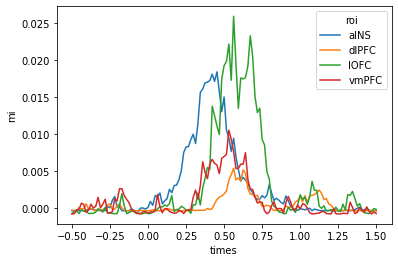

In [14]:
mi.plot(x='times', hue='roi')

# **3. How to handle the spatial dimension?**

<div class="alert alert-info"><p>

**THIS IS A VERY IMPORTANT SECTION !**
</p></div>

Inside a brain region, there's multiple sEEG contacts. A natural question is **how to handle all of those contacts and avoid loosing the very specific and precious information they contained?**

You've several strategies :
1. You can average the activity within a brain region (as we did above)
2. You can try to find significant activations at the contact level, for each subject
3. You can concatenate the activity across contacts inside a brain region
4. You can use more elaborated statistics to model how the information is distributed across contacts inside a brain region (Random-Effect at the contact level)

It's hard to recommand a single method, because, as always, it's data dependent. However, as a rule of thumb, I would advise avoiding meaning the activity **before estimating the information** as much as possible. It's probably better to extract the information at the single-contact level.

## 3.1 Extract the information on the mean activity inside a brain region

  0%|          | Subject 0 | model=pe | condition=rew | space=roi : 0/4 [00:00<?,       ?it/s]

Definition of an electrophysiological dataset
    Dataset composed of 4 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (ffx - cc)
    Evaluate true and permuted mi (n_perm=0, n_jobs=-1)


  0%|          | Estimating MI : 0/4 [00:00<?,       ?it/s]

<xarray.DataArray 'subject_0' (trials: 288, roi: 2, times: 129)>
array([[[-0.16181974, -0.2955156 , -0.83654255, ...,  0.5241728 ,
         -0.49835598, -0.88272893],
        [-0.15928042, -0.07754046,  0.09821701, ...,  0.05255038,
         -0.4784311 ,  0.0784598 ]],

       [[-0.46801478, -0.5404649 , -0.8396881 , ...,  2.5940983 ,
          2.5047302 ,  1.5011954 ],
        [ 0.7217249 ,  0.36927456, -0.33366498, ..., -1.9838252 ,
         -1.7444112 , -1.3753299 ]],

       [[-0.2946555 , -0.81586057, -0.64849275, ..., -0.07913525,
         -0.07557062, -0.07512819],
        [-1.1138847 , -0.94510245, -0.3521356 , ...,  1.8380456 ,
          1.4101346 ,  2.1061664 ]],

       ...,

       [[-0.10967048, -0.25948536, -0.27481067, ...,  2.1105258 ,
          2.2514193 ,  3.4545643 ],
        [ 0.02990863,  0.47971115,  0.08525403, ..., -1.500295  ,
         -1.3295761 , -1.3060205 ]],

       [[ 0.01862325, -0.26454028, -0.32786107, ..., -0.18639396,
         -0.41826957, -0.71718884],
        [ 0.45772484, -0.32025492, -0.7993766 , ..., -0.09794742,
         -0.9520852 , -0.8170517 ]],

       [[ 0.04448934,  0.7463437 ,  0.2638364 , ...,  0.26918527,
         -0.7042078 , -0.38113084],
        [ 0.41341987,  0.5155392 ,  0.6137322 , ...,  0.16353098,
          0.36955655, -0.01799088]]], dtype=float32)
Coordinates:
  * trials   (trials) int64 0 1 2 3 4 5 6 7 ... 280 281 282 283 284 285 286 287
    y        (trials) float64 0.0 1.0 1.0 0.7437 ... -0.9724 -0.7231 -0.5378
    subject  (trials) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * roi      (roi) object 'aINS' 'dlPFC'
    agg_ch   (roi) int64 0 0
  * times    (times) float64 -0.5 -0.4844 -0.4688 -0.4531 ... 1.469 1.484 1.5
Attributes:
    __version__:   0.4.0
    modality:      electrophysiology
    dtype:         SubjectEphy
    y_dtype:       float
    z_dtype:       none
    mi_type:       cc
    mi_repr:       I(x; y (continuous))
    sfreq:         64.0
    agg_ch:        True
    multivariate:  False
<xarray.DataArray 'subject_1' (trials: 144, roi: 1, times: 129)>
array([[[-0.2584719 ,  0.00311074,  0.2764771 , ...,  1.474181  ,
          1.2427444 ,  0.11859734]],

       [[ 0.40096354,  0.0644676 , -0.10727783, ..., -1.4077976 ,
         -1.0741203 , -1.026696  ]],

       [[ 0.00896096, -0.17261477, -0.22814319, ..., -1.1516649 ,
         -1.2811878 , -1.0947628 ]],

       ...,

       [[-0.31696108, -0.3399889 , -0.22420402, ..., -0.92178136,
         -1.0767963 , -1.1252654 ]],

       [[-0.17258535, -0.20229188,  0.4478964 , ..., -0.11303125,
         -0.10066237, -0.17238481]],

       [[-0.01751816, -0.31678933, -0.49142605, ..., -0.01893415,
          0.12903321, -0.2842691 ]]], dtype=float32)
Coordinates:
  * trials   (trials) int64 0 1 2 3 4 5 6 7 ... 136 137 138 139 140 141 142 143
    y        (trials) float64 0.0 0.0 0.0 1.0 ... 0.1944 -0.8555 0.2055 0.3638
    subject  (trials) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * roi      (roi) object 'aINS'
    agg_ch   (roi) int64 0
  * times    (times) float64 -0.5 -0.4844 -0.4688 -0.4531 ... 1.469 1.484 1.5
Attributes:
    __version__:   0.4.0
    modality:      electrophysiology
    dtype:         SubjectEphy
    y_dtype:       float
    z_dtype:       none
    mi_type:       cc
    mi_repr:       I(x; y (continuous))
    sfreq:         64.0
    agg_ch:        True
    multivariate:  False
<xarray.DataArray 'subject_2' (trials: 288, roi: 4, times: 129)>
array([[[-1.91057265e-01, -4.12543975e-02, -2.14001611e-02, ...,
         -2.11530685e+00, -2.24028993e+00, -1.99642730e+00],
        [ 3.78362507e-01, -1.18041605e-01,  1.75416887e-01, ...,
         -7.95855522e-02,  3.77144408e-03, -1.52018309e-01],
        [-6.01642787e-01, -8.75504017e-01, -1.04580939e+00, ...,
         -4.89717335e-01, -3.49725813e-01, -3.48862439e-01],
        [ 2.70570427e-01, -4.11526889e-01, -3.60873133e-01, ...,
         -2.54661411e-01, -2.08868742e-01,  6.45146221e-02]],

       [[-1.06188

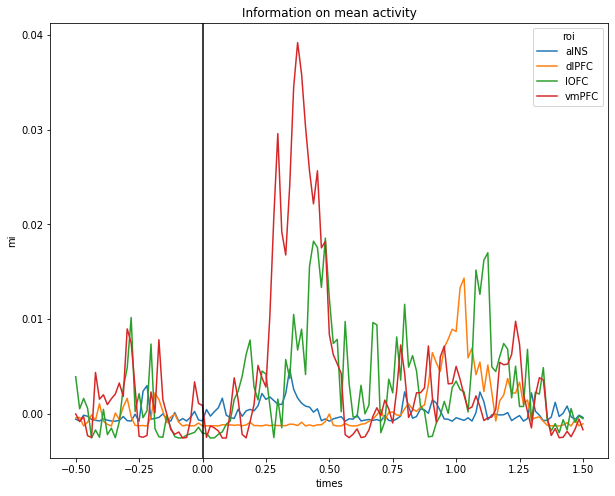

In [17]:
# load data and build the DatasetEphy
hga = load_ms(s_range=[0, 3], model='pe', condition='rew', space='roi',
              mean_roi=True)
ds = DatasetEphy(hga, y='pe', roi='roi', times='times')

# measure information
mi, _ = WfMi(mi_type='cc', inference='ffx').fit(ds, mcp=None)

# plot the result
plt.figure(figsize=(10, 8))
mi.plot(x='times', hue='roi')
plt.axvline(0., color='k')
plt.title("Information on mean activity");

ds

## 3.2 Extract the information at the single-contact level
### 3.2.1 For a single subject

  0%|          | Subject 0 | model=pe | condition=rew | space=channels : 0/1 [00:00<?,       ?it/s]

Definition of an electrophysiological dataset
    Dataset composed of 1 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (ffx - cc)
    Evaluate true and permuted mi (n_perm=0, n_jobs=-1)


  0%|          | Estimating MI : 0/5 [00:00<?,       ?it/s]

<xarray.DataArray 'subject_0' (trials: 240, roi: 5, times: 129)>
array([[[-0.27671027,  0.7499249 ,  0.49904022, ...,  0.09102062,
          0.81058663,  1.1421177 ],
        [ 0.22533816,  0.06677834,  0.69167924, ...,  3.19452   ,
          2.8899786 ,  4.257389  ],
        [ 0.9235091 , -0.1507581 , -0.31415075, ...,  0.6106012 ,
          0.99675477,  1.3268466 ],
        [ 1.0468702 ,  1.0844862 ,  1.4127469 , ...,  0.7684676 ,
          1.0887556 ,  1.0524963 ],
        [-0.8299315 , -0.8339797 , -0.7615329 , ...,  1.11532   ,
          1.0641747 ,  0.8732486 ]],

       [[-1.9218978 , -1.1912662 , -1.1083739 , ...,  0.8790561 ,
          0.67299646,  1.0706978 ],
        [-1.9449233 , -1.8321564 , -0.72506845, ...,  3.3073094 ,
          1.5260608 ,  1.3036729 ],
        [ 0.18202396,  0.31029046,  0.8612152 , ...,  1.726089  ,
          1.486663  ,  1.8213599 ],
        [-0.12174946,  0.1752846 , -0.29067862, ..., -0.26859444,
         -0.45128593, -0.858137  ],
        [ 0.5745613 ,  0.07672714, -0.24694484, ...,  0.10524487,
...
          2.1684692 ,  3.1429946 ],
        [ 0.5562088 , -0.26088643, -0.5802575 , ...,  0.3459869 ,
          0.63435745,  0.8154304 ],
        [ 0.23729154, -0.45131412, -0.5661963 , ..., -0.91259813,
         -1.119358  , -1.7482023 ],
        [-0.7522206 , -0.80346656, -0.6590085 , ...,  1.1641096 ,
          1.5981529 ,  0.94162536],
        [-0.31601298, -0.01414734, -0.45791492, ...,  0.27553785,
          0.30647334,  0.40300703]],

       [[-0.26958516, -0.33416864, -0.31418929, ..., -0.5755283 ,
         -0.20896965,  0.53357434],
        [-0.67518425,  0.81537133,  0.5712228 , ...,  2.1167161 ,
          1.8121451 ,  0.6509161 ],
        [ 2.126091  ,  1.5705668 ,  0.7151658 , ..., -0.28386432,
         -0.5395481 , -0.60451806],
        [ 2.0720217 ,  2.0747604 ,  1.5339533 , ...,  1.0551726 ,
          0.80964875,  0.6526803 ],
        [ 0.43330005,  0.5493605 ,  0.9593441 , ..., -0.86538374,
         -0.69336575, -0.34618807]]], dtype=float32)
Coordinates:
  * trials   (trials) int64 0 1 2 3 4 5 6 7 ... 232 233 234 235 236 237 238 239
    y        (trials) float64 0.0 1.0 0.0 0.7437 ... -0.4307 -0.3203 0.4987
    subject  (trials) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * roi      (roi) <U12 "suj5/X'2-X'1" "suj5/X'3-X'2" ... 'suj5/O2-O1'
    agg_ch   (roi) int64 0 0 0 0 0
  * times    (times) float64 -0.5 -0.4844 -0.4688 -0.4531 ... 1.469 1.484 1.5
Attributes:
    sfreq:         64.0
    __version__:   0.4.0
    modality:      electrophysiology
    dtype:         SubjectEphy
    y_dtype:       float
    z_dtype:       none
    mi_type:       cc
    mi_repr:       I(x; y (continuous))
    agg_ch:        True
    multivariate:  False

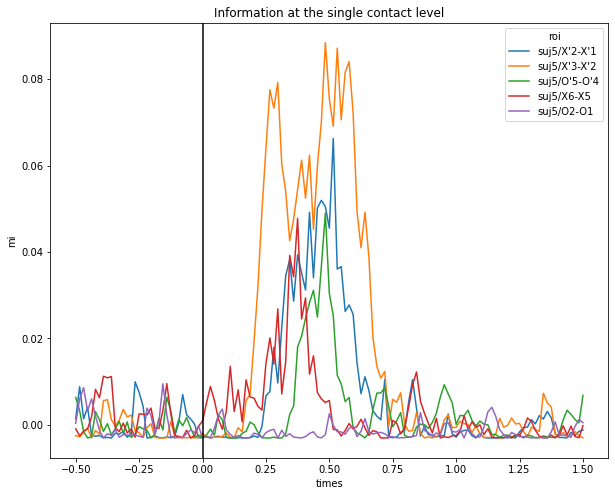

In [21]:
# load data and build the DatasetEphy
hga = load_ms(s_range=5, model='pe', condition='rew', space='channels')
hga
ds = DatasetEphy(hga, y='pe', roi='channels', times='times')

# measure information
mi, _ = WfMi(mi_type='cc', inference='ffx').fit(ds, mcp=None)

# plot the result
plt.figure(figsize=(10, 8))
mi.plot(x='times', hue='roi')
plt.axvline(0., color='k')
plt.title("Information at the single contact level");

ds

### 3.2.2 For multiple subjects

  0%|          | Subject 0 | model=pe | condition=rew | space=channels : 0/3 [00:00<?,       ?it/s]

Definition of an electrophysiological dataset
    Dataset composed of 3 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (ffx - cc)
    Evaluate true and permuted mi (n_perm=0, n_jobs=-1)


  0%|          | Estimating MI : 0/13 [00:00<?,       ?it/s]

<xarray.DataArray 'subject_0' (trials: 240, roi: 2, times: 129)>
array([[[ 0.21192235,  0.72830284,  0.69165826, ...,  1.9421154 ,
          0.29742542,  1.241406  ],
        [ 0.61670655,  0.817722  ,  0.5559789 , ...,  0.8252373 ,
          0.7121286 ,  0.7832431 ]],

       [[-0.3887279 , -0.31693307, -0.5888269 , ..., 14.374976  ,
         13.8677225 , 15.46017   ],
        [ 0.08245645,  0.59788746,  0.8184316 , ...,  2.393147  ,
          1.4652439 ,  1.7987863 ]],

       [[ 1.4517978 ,  1.21155   ,  0.9501936 , ...,  3.9626527 ,
          4.6416564 ,  7.244572  ],
        [-1.344311  , -0.82075816,  0.9004476 , ..., -0.33741713,
          0.4224237 ,  0.3551426 ]],

       ...,

       [[ 0.36031348, -0.35361817, -0.61010873, ...,  0.9266341 ,
         -0.6500678 ,  0.21796864],
        [ 0.62678695,  1.1928178 ,  1.7077204 , ..., -0.9893347 ,
         -0.30701286, -0.25862134]],

       [[-0.32315582, -0.51267356, -0.2578579 , ...,  1.4966538 ,
          3.9133143 ,  4.6957793 ],
        [-1.5517453 , -1.3237514 , -1.1141477 , ...,  1.1796619 ,
          2.8808415 ,  3.7111406 ]],

       [[ 0.9210941 ,  1.1270434 ,  0.73080003, ...,  5.061082  ,
          0.4306375 ,  0.8075813 ],
        [ 0.2185088 , -0.20663959, -0.2687854 , ...,  0.20710406,
          0.7220101 ,  1.3331858 ]]], dtype=float32)
Coordinates:
  * trials   (trials) int64 0 1 2 3 4 5 6 7 ... 232 233 234 235 236 237 238 239
    y        (trials) float64 1.0 1.0 0.0 0.7437 ... 0.1002 0.07455 -0.8494
    subject  (trials) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * roi      (roi) <U12 "suj3/X'2-X'1" "suj3/X'4-X'3"
    agg_ch   (roi) int64 0 0
  * times    (times) float64 -0.5 -0.4844 -0.4688 -0.4531 ... 1.469 1.484 1.5
Attributes:
    sfreq:         64.0
    __version__:   0.4.0
    modality:      electrophysiology
    dtype:         SubjectEphy
    y_dtype:       float
    z_dtype:       none
    mi_type:       cc
    mi_repr:       I(x; y (continuous))
    agg_ch:        True
    multivariate:  False
<xarray.DataArray 'subject_1' (trials: 287, roi: 6, times: 129)>
array([[[-8.21980774e-01, -6.80685401e-01, -9.05550122e-01, ...,
         -9.12338123e-02,  5.90627594e-03,  1.95374191e-01],
        [ 1.24216640e+00, -8.37370306e-02, -6.17846131e-01, ...,
          6.05997205e-01,  8.87233794e-01,  7.83706903e-01],
        [ 5.40017366e-01,  1.42501104e+00,  1.25638211e+00, ...,
          1.89581943e+00,  8.78425837e-01,  9.62470412e-01],
        [-1.77959085e-01, -3.04039836e-01, -3.52950811e-01, ...,
         -5.81773818e-01, -3.64884168e-01, -1.08975649e-01],
        [-5.28543703e-02, -2.01798141e-01, -6.21015489e-01, ...,
         -4.49335366e-01,  9.38852131e-02,  1.04526430e-01],
        [-1.08367538e+00, -9.21989858e-01, -7.63438702e-01, ...,
         -4.60004181e-01, -5.49460232e-01, -5.20804465e-01]],

       [[-8.77576172e-01, -6.29094601e-01, -3.90440464e-01, ...,
         -4.63897020e-01, -6.16522372e-01, -7.17045665e-01],
        [-8.24648201e-01,  3.82895558e-03, -1.96501061e-01, ...,
         -1.45917499e+00, -1.83881009e+00, -1.53406477e+00],
        [-1.57514834e+00, -5.71522951e-01, -8.69178295e-01, ...,
          7.96865821e-01,  1.20860422e+00,  5.58264256e-01],
        [-1.46139279e-01,  9.44442451e-02, -1.16378600e-02, ...,
...
        [ 5.66342890e-01,  9.87191796e-01,  1.18799484e+00, ...,
          1.78595948e+00,  2.35973811e+00,  1.52092206e+00],
        [ 3.80025178e-01,  7.82601595e-01,  1.78146613e+00, ...,
          4.18458557e+00,  4.10888624e+00,  3.70530057e+00],
        [ 5.80039263e-01,  2.75404334e-01,  1.90023318e-01, ...,
         -1.11050773e+00, -1.39645171e+00, -2.20831513e+00]],

       [[-9.97126520e-01, -1.06510150e+00, -1.19081938e+00, ...,
         -5.62288225e-01, -7.54384577e-01, -6.45626783e-01],
        [-1.30492222e+00, -1.11187708e+00, -1.45356357e+00, ...,
         -3.52891922e-01, -3.96644711e-01, -8.89869571e-01],
        [-1.19440842e+00, -1.20991492e+00, -1.36516500e+00, ...,
     

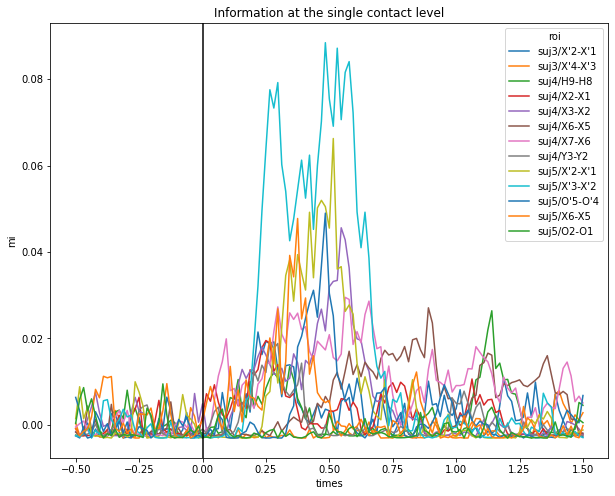

In [22]:
# load data and build the DatasetEphy
hga = load_ms(s_range=[3, 5], model='pe', condition='rew', space='channels')
ds = DatasetEphy(hga, y='pe', roi='channels', times='times')

# measure information
mi, _ = WfMi(mi_type='cc', inference='ffx').fit(ds, mcp=None)

# plot the result
plt.figure(figsize=(10, 8))
mi.plot(x='times', hue='roi')
plt.axvline(0., color='k')
plt.title("Information at the single contact level");

ds

## 3.3 Concatenate the activity across contacts

  0%|          | Subject 0 | model=pe | condition=rew | space=roi : 0/1 [00:00<?,       ?it/s]

Definition of an electrophysiological dataset
    Dataset composed of 1 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (ffx - cc)
    Evaluate true and permuted mi (n_perm=0, n_jobs=-1)


  0%|          | Estimating MI : 0/2 [00:00<?,       ?it/s]

<xarray.DataArray 'subject_0' (trials: 240, roi: 5, times: 129)>
array([[[-0.27671027,  0.7499249 ,  0.49904022, ...,  0.09102062,
          0.81058663,  1.1421177 ],
        [ 0.22533816,  0.06677834,  0.69167924, ...,  3.19452   ,
          2.8899786 ,  4.257389  ],
        [ 0.9235091 , -0.1507581 , -0.31415075, ...,  0.6106012 ,
          0.99675477,  1.3268466 ],
        [ 1.0468702 ,  1.0844862 ,  1.4127469 , ...,  0.7684676 ,
          1.0887556 ,  1.0524963 ],
        [-0.8299315 , -0.8339797 , -0.7615329 , ...,  1.11532   ,
          1.0641747 ,  0.8732486 ]],

       [[-1.9218978 , -1.1912662 , -1.1083739 , ...,  0.8790561 ,
          0.67299646,  1.0706978 ],
        [-1.9449233 , -1.8321564 , -0.72506845, ...,  3.3073094 ,
          1.5260608 ,  1.3036729 ],
        [ 0.18202396,  0.31029046,  0.8612152 , ...,  1.726089  ,
          1.486663  ,  1.8213599 ],
        [-0.12174946,  0.1752846 , -0.29067862, ..., -0.26859444,
         -0.45128593, -0.858137  ],
        [ 0.5745613 ,  0.07672714, -0.24694484, ...,  0.10524487,
...
          2.1684692 ,  3.1429946 ],
        [ 0.5562088 , -0.26088643, -0.5802575 , ...,  0.3459869 ,
          0.63435745,  0.8154304 ],
        [ 0.23729154, -0.45131412, -0.5661963 , ..., -0.91259813,
         -1.119358  , -1.7482023 ],
        [-0.7522206 , -0.80346656, -0.6590085 , ...,  1.1641096 ,
          1.5981529 ,  0.94162536],
        [-0.31601298, -0.01414734, -0.45791492, ...,  0.27553785,
          0.30647334,  0.40300703]],

       [[-0.26958516, -0.33416864, -0.31418929, ..., -0.5755283 ,
         -0.20896965,  0.53357434],
        [-0.67518425,  0.81537133,  0.5712228 , ...,  2.1167161 ,
          1.8121451 ,  0.6509161 ],
        [ 2.126091  ,  1.5705668 ,  0.7151658 , ..., -0.28386432,
         -0.5395481 , -0.60451806],
        [ 2.0720217 ,  2.0747604 ,  1.5339533 , ...,  1.0551726 ,
          0.80964875,  0.6526803 ],
        [ 0.43330005,  0.5493605 ,  0.9593441 , ..., -0.86538374,
         -0.69336575, -0.34618807]]], dtype=float32)
Coordinates:
  * trials   (trials) int64 0 1 2 3 4 5 6 7 ... 232 233 234 235 236 237 238 239
    y        (trials) float64 0.0 1.0 0.0 0.7437 ... -0.4307 -0.3203 0.4987
    subject  (trials) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * roi      (roi) <U5 'aINS' 'aINS' 'vmPFC' 'aINS' 'vmPFC'
    agg_ch   (roi) int64 0 0 0 0 0
  * times    (times) float64 -0.5 -0.4844 -0.4688 -0.4531 ... 1.469 1.484 1.5
Attributes:
    sfreq:         64.0
    __version__:   0.4.0
    modality:      electrophysiology
    dtype:         SubjectEphy
    y_dtype:       float
    z_dtype:       none
    mi_type:       cc
    mi_repr:       I(x; y (continuous))
    agg_ch:        True
    multivariate:  False

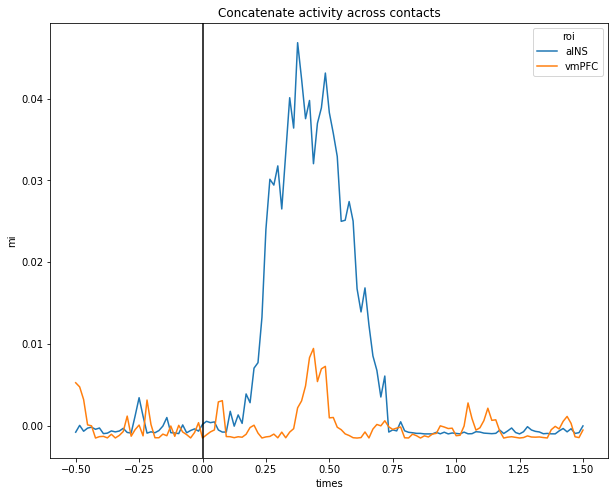

In [24]:
# load data and build the DatasetEphy
hga = load_ms(s_range=5, model='pe', condition='rew', space='roi', mean_roi=False)
hga[0]
ds = DatasetEphy(hga, y='pe', roi='roi', times='times')

# measure information
mi, _ = WfMi(mi_type='cc', inference='ffx').fit(ds, mcp=None)

# plot the result
plt.figure(figsize=(10, 8))
mi.plot(x='times', hue='roi')
plt.axvline(0., color='k')
plt.title("Concatenate activity across contacts");

ds

---
# **4. Use alternative estimators of information** (Bonus)

To estimate the quantity of information shared between the brain data and an external variable, Frites uses by default metrics from the information-theory (i.e. _Gaussian Copula Mutual Information (GCMI)_). The GCMI is a good estimator because it's fast, it can detect many types of relations and it's relatively robust to the presence of noise in the data. However, more powerfull estimators exist, such as in the field of machine learning. Frites allows to provide custom estimators and also include some basic ones (like correlation).

## 4.1 Define a custom estimator

In this part, we define an estimator for computing the correlation between two continuous variables

In [25]:
from frites.estimator import CustomEstimator

# function for computing 
def correlation(x, y):
    """Compute the correlation between two variables.
    """
    n_var, n_mv, n_samples = x.shape
    corr = np.zeros((n_var,))
    for k in range(n_var):
        corr[k] = np.corrcoef(x[k, ...], y[k, ...])[0, 1]
    return corr

# define you custom 
est = CustomEstimator('custom_correlation', 'cc', correlation,
                      multivariate=False)

custom_correlation (mi_type=cc)
    Testing function's signature [PASSED]
    Testing univariate inputs [PASSED]
    Testing univariate output type [PASSED]
    Testing univariate outputs shape [PASSED]


## 4.2 Use this custom estimator

  0%|          | Subject 0 | model=pe | condition=rew | space=roi : 0/12 [00:00<?,       ?it/s]

Definition of an electrophysiological dataset
    Dataset composed of 12 subjects / sessions
    At least False subjects / roi required
    Supported MI definition I(x; y (continuous)) (cc)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (rfx - cc)
    Evaluate true and permuted mi (n_perm=0, n_jobs=-1)


  0%|          | Estimating MI : 0/4 [00:00<?,       ?it/s]

    Mean mi across subjects


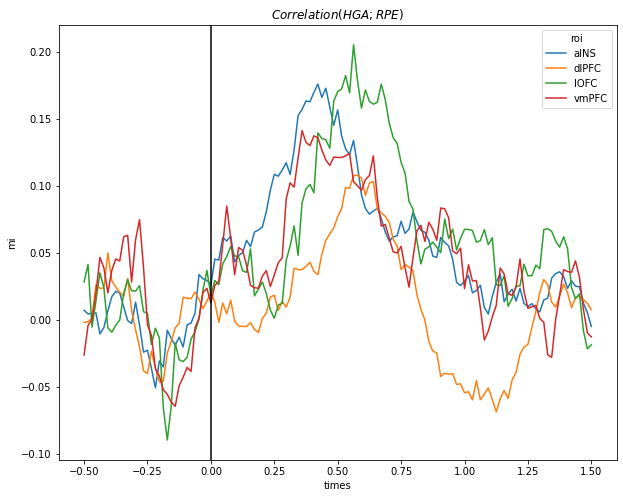

In [26]:
# load data and build the DatasetEphy
hga = load_ms(model='pe', condition='rew', space='roi')
ds = DatasetEphy(hga, y='pe', roi='roi', times='times')

# measure information
mi, _ = WfMi(mi_type='cc', estimator=est).fit(ds, mcp=None)

# plot the result
plt.figure(figsize=(10, 8))
mi.plot(x='times', hue='roi')
plt.axvline(0., color='k')
plt.title(r"$Correlation(HGA; RPE)$");


---
# **---- Test yourself ! ----**
## **1. Data loading**
### 1.1 Load the data of a single subject

<div class="alert alert-warning"><p>

**[Instructions]**

Load the data of :
- Subject 6 only (`s_range`)
- During the reward condition (`condition`)
- For the task-related variable, use the outcome (`model`)
- The spatial dimension should be described with channel names (`space`)
</p></div>

In [ ]:
# write your answer

### 1.2 Load the data of a multiple subjects

<div class="alert alert-warning"><p>

**[Instructions]**

Same but for subjects between [6, 10]
</p></div>

In [ ]:
# write your answer

### 1.3 Switch condition and model

<div class="alert alert-warning"><p>

**[Instructions]**

Load the data of :
- Subject 6 only
- For the model and condition, use the Punishment Prediction Error
- The spatial dimension should be described with brain region names
</p></div>

In [ ]:
# write your answer

---
## **2. Measuring information**
### 2.1 Model-free analysis for a single subject

<div class="alert alert-warning"><p>

**[Instructions]**

On **subject 6**, what is the **channel** name that share the maximum of information between **outcomes** during the **reward** condition?
</p></div>

In [ ]:
# write your answer

### 2.2 Model-free analysis across all of the subjects

<div class="alert alert-warning"><p>

**[Instructions]**

Across all of the subjects, what is the name of the **brain region** that seems to better differentiate the **outcomes** during different **contexts**? (i.e. `condition='context'`)
</p></div>

In [ ]:
# write your answer

### 2.3 Model-based analysis for a single subject

<div class="alert alert-warning"><p>

**[Instructions]**

For subject 6, what is the name of the **channel** sharing the most information with the **reaction time** (`model='rt'`) during the **reward** condition?
</p></div>

In [ ]:
# write your answer

### 2.4 Model-based analysis for multiple subjects

<div class="alert alert-warning"><p>

**[Instructions]**

Across all of the subjects, what is the name of the **brain region** sharing the most information with the **punishment** (`condition`) **prediction error** (`model`)?
</p></div>

In [ ]:
# write your answer

### 2.5 Avoid taking the mean of neural activity

If you didn't change anything, the function that load multiple subjects takes the mean of the high-gamma activity per brain region (`space='roi'`). As  said before, this might not be the best way to take full benefit of the information contained at the single-contact level. In this last exercise, we are going to avoid this behavior by concatenating the activity across contacts withing a brain region.

<div class="alert alert-warning"><p>

**[Instructions]**

Across **all of the subjects**, what is the name of the **brain region** that share the maximum amount of information with the **reaction time** during the reward condition? And off course, without taking the mean of HGA within region (`mean_roi=False`) !

</p></div>

In [ ]:
# write your answer